In [1]:
#!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 43.9 GB  | Proc size: 511.3 MB
GPU RAM Free: 13375MB | Used: 2795MB | Util  17% | Total 16376MB


In [4]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))]
    )
    trainset = FashionMNIST("./dataset", train=True, download=True, transform=transform)
    testset = FashionMNIST("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [7]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [8]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [9]:
strategy = FedCustom()

In [ ]:

#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-29 17:01:50,019	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 35824167321.0, 'node:127.0.0.1': 1.0, 'memory': 73589723751.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12560) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.384629726409912and 9habhhahah
this is tehb mode time [25.38]
This is ths last time not a fantasy 25.6176278591156and 7habhhahah
this is tehb mode time [25.38, 25.62]
This is ths last time not a fantasy 25.738622903823853and 5habhhahah
this is tehb mode time [25.38, 25.62, 25.74]
This is ths last time not a fantasy 25.74562931060791and 8habhhahah
this is tehb mode time [25.38, 25.62, 25.74, 25.75]
This is ths last time not a fantasy 28.126070261001587and 6habhhahah
this is tehb mode time [25.38, 25.62, 25.74, 25.75, 28.13]
This is ths last time not a fantasy 25.919621467590332and 1habhhahah
this is tehb mode time [25.38, 25.62, 25.74, 25.75, 28.13, 25.92]
This is ths last time not a fantasy 25.549630641937256and 0habhhahah
this is tehb mode time [25.38, 25.62, 25.74, 25.75, 28.13, 25.92, 25.55]
This is ths last time not a fantasy 27.767389059066772and 4habhhahah
this is tehb mode time [25.38, 25.62, 25.74, 25.75, 28.13, 25.92, 25.55, 27.77]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24492) Training time for Client 2: 25.54 seconds
(ClientAppActor pid=24492) Epoch 8: train loss 0.007704, accuracy 0.905556 [repeated 4x across cluster]
(ClientAppActor pid=25436) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.28591012954712and 0habhhahah
this is tehb mode time [22.29]
This is ths last time not a fantasy 23.08171582221985and 8habhhahah
this is tehb mode time [22.29, 23.08]
This is ths last time not a fantasy 23.27272057533264and 7habhhahah
this is tehb mode time [22.29, 23.08, 23.27]
This is ths last time not a fantasy 22.736727237701416and 4habhhahah
this is tehb mode time [22.29, 23.08, 23.27, 22.74]
This is ths last time not a fantasy 25.79308819770813and 3habhhahah
this is tehb mode time [22.29, 23.08, 23.27, 22.74, 25.79]
This is ths last time not a fantasy 22.698734045028687and 6habhhahah
this is tehb mode time [22.29, 23.08, 23.27, 22.74, 25.79, 22.7]
This is ths last time not a fantasy 22.811726570129395and 5habhhahah
this is tehb mode time [22.29, 23.08, 23.27, 22.74, 25.79, 22.7, 22.81]
This is ths last time not a fantasy 22.42004632949829and 1habhhahah
this is tehb mode time [22.29, 23.08, 23.27, 22.74, 25.79, 22.7, 22.81, 22.42]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29136) Training time for Client 9: 25.22 seconds
(ClientAppActor pid=29136) Epoch 8: train loss 0.005176, accuracy 0.935926 [repeated 4x across cluster]
(ClientAppActor pid=41448) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.434581995010376and 5habhhahah
this is tehb mode time [22.43]
This is ths last time not a fantasy 22.593589067459106and 4habhhahah
this is tehb mode time [22.43, 22.59]
This is ths last time not a fantasy 22.931577920913696and 7habhhahah
this is tehb mode time [22.43, 22.59, 22.93]
This is ths last time not a fantasy 22.46957540512085and 1habhhahah
this is tehb mode time [22.43, 22.59, 22.93, 22.47]
This is ths last time not a fantasy 23.27058506011963and 3habhhahah
this is tehb mode time [22.43, 22.59, 22.93, 22.47, 23.27]
This is ths last time not a fantasy 25.190853357315063and 2habhhahah
this is tehb mode time [22.43, 22.59, 22.93, 22.47, 23.27, 25.19]
This is ths last time not a fantasy 26.283373832702637and 0habhhahah
this is tehb mode time [22.43, 22.59, 22.93, 22.47, 23.27, 25.19, 26.28]
This is ths last time not a fantasy 22.5985848903656and 6habhhahah
this is tehb mode time [22.43, 22.59, 22.93, 22.47, 23.27, 25.19, 26.28, 22.6]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12560) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.698169708251953and 6habhhahah
this is tehb mode time [22.7]
This is ths last time not a fantasy 25.034072875976562and 9habhhahah
this is tehb mode time [22.7, 25.03]
This is ths last time not a fantasy 23.26017427444458and 2habhhahah
this is tehb mode time [22.7, 25.03, 23.26]
This is ths last time not a fantasy 22.637166738510132and 0habhhahah
this is tehb mode time [22.7, 25.03, 23.26, 22.64]
This is ths last time not a fantasy 22.4063823223114and 3habhhahah
this is tehb mode time [22.7, 25.03, 23.26, 22.64, 22.41]
This is ths last time not a fantasy 27.474125862121582and 8habhhahah
this is tehb mode time [22.7, 25.03, 23.26, 22.64, 22.41, 27.47]
This is ths last time not a fantasy 22.782519817352295and 7habhhahah
this is tehb mode time [22.7, 25.03, 23.26, 22.64, 22.41, 27.47, 22.78]
This is ths last time not a fantasy 25.353822231292725and 1habhhahah
this is tehb mode time [22.7, 25.03, 23.26, 22.64, 22.41, 27.47, 22.78, 25.35]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=12560) Training time for Client 4: 24.95 seconds


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=25436) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.09351396560669and 3habhhahah
this is tehb mode time [25.09]
This is ths last time not a fantasy 22.846073150634766and 1habhhahah
this is tehb mode time [25.09, 22.85]
This is ths last time not a fantasy 23.06607699394226and 0habhhahah
this is tehb mode time [25.09, 22.85, 23.07]
This is ths last time not a fantasy 24.948782205581665and 4habhhahah
this is tehb mode time [25.09, 22.85, 23.07, 24.95]
This is ths last time not a fantasy 22.531083822250366and 8habhhahah
this is tehb mode time [25.09, 22.85, 23.07, 24.95, 22.53]
This is ths last time not a fantasy 22.483906984329224and 6habhhahah
this is tehb mode time [25.09, 22.85, 23.07, 24.95, 22.53, 22.48]
This is ths last time not a fantasy 22.40508008003235and 7habhhahah
this is tehb mode time [25.09, 22.85, 23.07, 24.95, 22.53, 22.48, 22.41]
This is ths last time not a fantasy 24.99178123474121and 5habhhahah
this is tehb mode time [25.09, 22.85, 23.07, 24.95, 22.53, 22.48, 22.41, 24.99]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41448) Training time for Client 9: 27.54 seconds
(ClientAppActor pid=41448) Epoch 9: train loss 0.002215, accuracy 0.975556 [repeated 4x across cluster]
(ClientAppActor pid=25436) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.945369482040405and 6habhhahah
this is tehb mode time [24.95]
This is ths last time not a fantasy 22.770739316940308and 1habhhahah
this is tehb mode time [24.95, 22.77]
This is ths last time not a fantasy 22.640594959259033and 5habhhahah
this is tehb mode time [24.95, 22.77, 22.64]
This is ths last time not a fantasy 22.509286403656006and 0habhhahah
this is tehb mode time [24.95, 22.77, 22.64, 22.51]
This is ths last time not a fantasy 22.58959150314331and 4habhhahah
this is tehb mode time [24.95, 22.77, 22.64, 22.51, 22.59]
This is ths last time not a fantasy 22.738591194152832and 8habhhahah
this is tehb mode time [24.95, 22.77, 22.64, 22.51, 22.59, 22.74]
This is ths last time not a fantasy 22.995887756347656and 3habhhahah
this is tehb mode time [24.95, 22.77, 22.64, 22.51, 22.59, 22.74, 23.0]
This is ths last time not a fantasy 25.07837700843811and 7habhhahah
this is tehb mode time [24.95, 22.77, 22.64, 22.51, 22.59, 22.74, 23.0, 25.08]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40256) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.77507972717285and 2habhhahah
this is tehb mode time [24.78]
This is ths last time not a fantasy 25.311084032058716and 9habhhahah
this is tehb mode time [24.78, 25.31]
This is ths last time not a fantasy 22.580626964569092and 6habhhahah
this is tehb mode time [24.78, 25.31, 22.58]
This is ths last time not a fantasy 22.546082735061646and 8habhhahah
this is tehb mode time [24.78, 25.31, 22.58, 22.55]
This is ths last time not a fantasy 22.882079124450684and 1habhhahah
this is tehb mode time [24.78, 25.31, 22.58, 22.55, 22.88]
This is ths last time not a fantasy 22.745094776153564and 3habhhahah
this is tehb mode time [24.78, 25.31, 22.58, 22.55, 22.88, 22.75]
This is ths last time not a fantasy 22.221090078353882and 7habhhahah
this is tehb mode time [24.78, 25.31, 22.58, 22.55, 22.88, 22.75, 22.22]
This is ths last time not a fantasy 22.865083694458008and 5habhhahah
this is tehb mode time [24.78, 25.31, 22.58, 22.55, 22.88, 22.75, 22.22, 22.87]
This 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=25436) Training time for Client 4: 25.01 seconds
(ClientAppActor pid=25436) Epoch 8: train loss 0.002672, accuracy 0.968148 [repeated 4x across cluster]
(ClientAppActor pid=12560) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.700533151626587and 1habhhahah
this is tehb mode time [22.7]
This is ths last time not a fantasy 23.118509769439697and 9habhhahah
this is tehb mode time [22.7, 23.12]
This is ths last time not a fantasy 22.962525844573975and 2habhhahah
this is tehb mode time [22.7, 23.12, 22.96]
This is ths last time not a fantasy 22.80853009223938and 3habhhahah
this is tehb mode time [22.7, 23.12, 22.96, 22.81]
This is ths last time not a fantasy 25.014737129211426and 4habhhahah
this is tehb mode time [22.7, 23.12, 22.96, 22.81, 25.01]
This is ths last time not a fantasy 22.37852668762207and 7habhhahah
this is tehb mode time [22.7, 23.12, 22.96, 22.81, 25.01, 22.38]
This is ths last time not a fantasy 22.48352861404419and 6habhhahah
this is tehb mode time [22.7, 23.12, 22.96, 22.81, 25.01, 22.38, 22.48]
This is ths last time not a fantasy 22.621532201766968and 5habhhahah
this is tehb mode time [22.7, 23.12, 22.96, 22.81, 25.01, 22.38, 22.48, 22.62]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12560) Training time for Client 8: 25.40 seconds
(ClientAppActor pid=12560) Epoch 8: train loss 0.000939, accuracy 0.989815 [repeated 4x across cluster]
(ClientAppActor pid=25436) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.400926113128662and 8habhhahah
this is tehb mode time [25.4]
This is ths last time not a fantasy 22.49091148376465and 4habhhahah
this is tehb mode time [25.4, 22.49]
This is ths last time not a fantasy 23.200090408325195and 2habhhahah
this is tehb mode time [25.4, 22.49, 23.2]
This is ths last time not a fantasy 23.162092447280884and 6habhhahah
this is tehb mode time [25.4, 22.49, 23.2, 23.16]
This is ths last time not a fantasy 22.938091278076172and 3habhhahah
this is tehb mode time [25.4, 22.49, 23.2, 23.16, 22.94]
This is ths last time not a fantasy 25.275447368621826and 7habhhahah
this is tehb mode time [25.4, 22.49, 23.2, 23.16, 22.94, 25.28]
This is ths last time not a fantasy 22.18823766708374and 9habhhahah
this is tehb mode time [25.4, 22.49, 23.2, 23.16, 22.94, 25.28, 22.19]
This is ths last time not a fantasy 22.537227392196655and 1habhhahah
this is tehb mode time [25.4, 22.49, 23.2, 23.16, 22.94, 25.28, 22.19, 22.54]
This is ths last tim

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24492) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 519.84s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.015028410298128922
INFO :      		round 2: 0.011054708508153755
INFO :      		round 3: 0.01093500293729206
INFO :      		round 4: 0.011316529477325577
INFO :      		round 5: 0.012107266007922592
INFO :      		round 6: 0.013001571838899207
INFO :      		round 7: 0.013694924408104272
INFO :      		round 8: 0.014267826772605378
INFO :      		round 9: 0.014810654656806341
INFO :      		round 10: 0.015768754522626598
INFO :      


History (loss, distributed):
	round 1: 0.015028410298128922
	round 2: 0.011054708508153755
	round 3: 0.01093500293729206
	round 4: 0.011316529477325577
	round 5: 0.012107266007922592
	round 6: 0.013001571838899207
	round 7: 0.013694924408104272
	round 8: 0.014267826772605378
	round 9: 0.014810654656806341
	round 10: 0.015768754522626598

C:\Users\Admin\AppData\Local\Temp\ipykernel_46964\1782018156.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
C:\Users\Admin\AppData\Local\Temp\ipykernel_46964\1782018156.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)


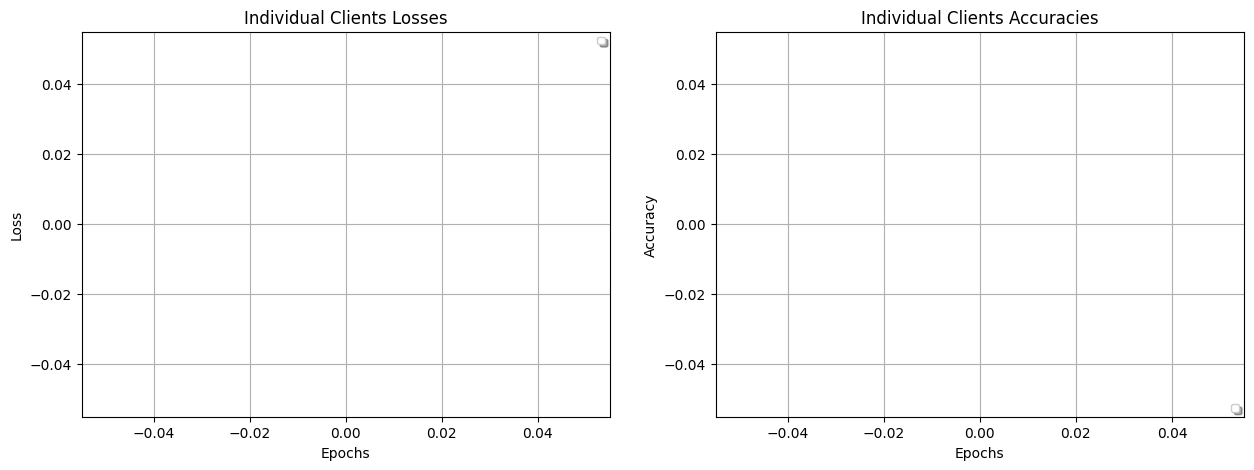

In [10]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

In [11]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    client_ids.sort()
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Rounds")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Individual Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend(loc='upper right', fontsize='x-small', shadow=True, ncol=len(client_ids))

    plt.show()

#plot_times(strategy.client_training_times)

In [12]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [14]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [16]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-29 17:10:41,544	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 73429258036.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 35755396300.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5400) [Client 2] get_parameters
(ClientAppActor pid=5400) [Client 0] fit, config: {}
(ClientAppActor pid=5400) Epoch 0: train loss 0.036681, accuracy 0.576481
(ClientAppActor pid=34872) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=5400) Epoch 1: train loss 0.021167, accuracy 0.731852
(ClientAppActor pid=34872) Epoch 0: train loss 0.036066, accuracy 0.583333 [repeated 4x across cluster]
(ClientAppActor pid=41260) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34872) Epoch 2: train loss 0.018076, accuracy 0.776296 [repeated 15x across cluster]
(ClientAppActor pid=20276) Epoch 4: train loss 0.015135, accuracy 0.814444 [repeated 16x across cluster]
(ClientAppActor pid=41260) Epoch 6: train loss 0.013672, accuracy 0.833519 [repeated 17x across cluster]
(ClientAppActor pid=5400) [Client 4] fit, config: {}
(ClientAppActor pid=41260) Epoch 8: train loss 0.012339, accuracy 0.848704 [repeated 15x across cluster]
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34872) [Client 7] evaluate, config: {}
(ClientAppActor pid=34872) Client 7 loss 0.015852100501457852
(ClientAppActor pid=34872) Client 7 accuracy 0.8083333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5400) [Client 7] fit, config: {}
(ClientAppActor pid=34872) Epoch 9: train loss 0.010901, accuracy 0.868889
(ClientAppActor pid=34872) Epoch 0: train loss 0.013753, accuracy 0.842407
(ClientAppActor pid=5400) [Client 9] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=5400) Client 9 loss 0.0185778746008873 [repeated 9x across cluster]
(ClientAppActor pid=5400) Client 9 accuracy 0.7683333333333333 [repeated 9x across cluster]
(ClientAppActor pid=42392) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=34872) Epoch 2: train loss 0.011334, accuracy 0.867222 [repeated 16x across cluster]
(ClientAppActor pid=34872) Epoch 4: train loss 0.009928, accuracy 0.881852 [repeated 16x across cluster]
(ClientAppActor pid=13092) Epoch 6: train loss 0.008341, accuracy 0.897037 [repeated 16x across cluster]
(ClientAppActor pid=31596) Epoch 8: train loss 0.007904, accuracy 0.902593 [repeated 16x across cluster]
(ClientAppActor pid=31596) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=42392) [Client 8] evaluate, config: {}
(ClientAppActor pid=42392) Client 8 loss 0.010265426846841971
(ClientAppActor pid=42392) Client 8 accuracy 0.8983333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31596) [Client 6] fit, config: {}
(ClientAppActor pid=42392) Epoch 9: train loss 0.007659, accuracy 0.911852 [repeated 3x across cluster]
(ClientAppActor pid=31596) [Client 0] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=31596) Client 0 loss 0.012795847405989965 [repeated 9x across cluster]
(ClientAppActor pid=31596) Client 0 accuracy 0.8533333333333334 [repeated 9x across cluster]
(ClientAppActor pid=20276) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=13092) Epoch 1: train loss 0.009546, accuracy 0.885741 [repeated 13x across cluster]
(ClientAppActor pid=20276) Epoch 3: train loss 0.008052, accuracy 0.901111 [repeated 16x across cluster]
(ClientAppActor pid=20276) Epoch 5: train loss 0.006740, accuracy 0.917037 [repeated 16x across cluster]
(ClientAppActor pid=20276) 
(ClientAppActor pid=20276) Epoch 7: train loss 0.005669, accuracy 0.928889 [repeated 17x across cluster]
(ClientAppActor pid=21216) [Client 0] f

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21216) [Client 5] evaluate, config: {}
(ClientAppActor pid=21216) Client 5 loss 0.014350224435329437
(ClientAppActor pid=21216) Client 5 accuracy 0.85


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41260) [Client 3] fit, config: {}
(ClientAppActor pid=31596) Epoch 0: train loss 0.010121, accuracy 0.887037 [repeated 9x across cluster]
(ClientAppActor pid=41260) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=41260) Client 4 loss 0.01117881233493487 [repeated 9x across cluster]
(ClientAppActor pid=41260) Client 4 accuracy 0.8766666666666667 [repeated 9x across cluster]
(ClientAppActor pid=31596) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=21216) Epoch 3: train loss 0.006134, accuracy 0.926852 [repeated 17x across cluster]
(ClientAppActor pid=21216) Epoch 5: train loss 0.005094, accuracy 0.938148 [repeated 16x across cluster]
(ClientAppActor pid=41260) Epoch 7: train loss 0.004092, accuracy 0.948519 [repeated 17x across cluster]
(ClientAppActor pid=21216) [Client 9] fit, config: {}
(ClientAppActor pid=41260) Epoch 9: train loss 0.003132, accuracy 0.963148 [repeated 16x across cluster]
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41260) [Client 3] evaluate, config: {}
(ClientAppActor pid=41260) Client 3 loss 0.009410808968047302
(ClientAppActor pid=41260) Client 3 accuracy 0.915


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20276) [Client 1] fit, config: {}
(ClientAppActor pid=20276) Epoch 0: train loss 0.008885, accuracy 0.898889 [repeated 2x across cluster]
(ClientAppActor pid=20276) [Client 1] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=20276) Client 1 loss 0.010345530820389588 [repeated 9x across cluster]
(ClientAppActor pid=20276) Client 1 accuracy 0.8966666666666666 [repeated 9x across cluster]
(ClientAppActor pid=31596) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=42392) Epoch 2: train loss 0.005890, accuracy 0.932222 [repeated 16x across cluster]
(ClientAppActor pid=20276) Epoch 4: train loss 0.004054, accuracy 0.949815 [repeated 17x across cluster]
(ClientAppActor pid=21216) Epoch 6: train loss 0.003653, accuracy 0.955185 [repeated 17x across cluster]
(ClientAppActor pid=13092) Epoch 8: train loss 0.002487, accuracy 0.972407 [repeated 17x across cluster]
(ClientAppActor pid=5400) [Client 7] fit, config: {}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21216) [Client 1] evaluate, config: {}
(ClientAppActor pid=21216) Client 1 loss 0.010921851309637229
(ClientAppActor pid=21216) Client 1 accuracy 0.9033333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5400) [Client 2] fit, config: {}
(ClientAppActor pid=21216) Epoch 9: train loss 0.002765, accuracy 0.969259 [repeated 3x across cluster]
(ClientAppActor pid=5400) [Client 0] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=5400) Client 0 loss 0.015078971510132154 [repeated 9x across cluster]
(ClientAppActor pid=5400) Client 0 accuracy 0.8683333333333333 [repeated 9x across cluster]
(ClientAppActor pid=31596) [Client 0] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=41260) Epoch 1: train loss 0.006065, accuracy 0.932037 [repeated 12x across cluster]
(ClientAppActor pid=41260) Epoch 3: train loss 0.004241, accuracy 0.948704 [repeated 17x across cluster]
(ClientAppActor pid=41260) Epoch 5: train loss 0.003005, accuracy 0.962593 [repeated 16x across cluster]
(ClientAppActor pid=20276) Epoch 7: train loss 0.002824, accuracy 0.967593 [repeated 17x across cluster]
(ClientAppActor pid=21216) [Client 5] fit, config: {}
(ClientAppActor p

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21216) Epoch 9: train loss 0.002331, accuracy 0.973889 [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 4] evaluate, config: {}
(ClientAppActor pid=21216) Client 4 loss 0.014012247286736966
(ClientAppActor pid=21216) Client 4 accuracy 0.8783333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34872) [Client 4] fit, config: {}
(ClientAppActor pid=34872) Epoch 1: train loss 0.005194, accuracy 0.936852 [repeated 10x across cluster]
(ClientAppActor pid=34872) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=34872) Client 6 loss 0.012217114977538586 [repeated 9x across cluster]
(ClientAppActor pid=34872) Client 6 accuracy 0.8866666666666667 [repeated 9x across cluster]
(ClientAppActor pid=31596) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=34872) Epoch 3: train loss 0.003486, accuracy 0.960926 [repeated 16x across cluster]
(ClientAppActor pid=41260) Epoch 5: train loss 0.002304, accuracy 0.974444 [repeated 17x across cluster]
(ClientAppActor pid=41260) Epoch 7: train loss 0.001804, accuracy 0.979630 [repeated 17x across cluster]
(ClientAppActor pid=34872) [Client 5] fit, config: {}
(ClientAppActor pid=41260) Epoch 9: train loss 0.001924, accuracy 0.974630 [repeated 16x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21216) [Client 5] evaluate, config: {}
(ClientAppActor pid=21216) Client 5 loss 0.018876909092068673
(ClientAppActor pid=21216) Client 5 accuracy 0.8683333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34872) [Client 0] fit, config: {}
(ClientAppActor pid=13092) Epoch 0: train loss 0.008272, accuracy 0.910000 [repeated 8x across cluster]
(ClientAppActor pid=34872) [Client 7] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=34872) Client 7 loss 0.01337586559355259 [repeated 9x across cluster]
(ClientAppActor pid=34872) Client 7 accuracy 0.89 [repeated 9x across cluster]
(ClientAppActor pid=13092) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=42392) Epoch 2: train loss 0.003491, accuracy 0.959630 [repeated 16x across cluster]
(ClientAppActor pid=42392) Epoch 4: train loss 0.002526, accuracy 0.973333 [repeated 16x across cluster]
(ClientAppActor pid=20276) Epoch 6: train loss 0.001702, accuracy 0.981481 [repeated 16x across cluster]
(ClientAppActor pid=20276) Epoch 8: train loss 0.001239, accuracy 0.985370 [repeated 16x across cluster]
(ClientAppActor pid=34872) [Client 3] fit, config: {}
(ClientAppActor pid=34872) E

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34872) Epoch 9: train loss 0.001217, accuracy 0.985741 [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 5] evaluate, config: {}
(ClientAppActor pid=21216) Client 5 loss 0.019436673372983933
(ClientAppActor pid=21216) Client 5 accuracy 0.8716666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21216) [Client 1] fit, config: {}
(ClientAppActor pid=13092) Epoch 1: train loss 0.003992, accuracy 0.951111 [repeated 10x across cluster]
(ClientAppActor pid=21216) [Client 3] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=21216) Client 3 loss 0.012264926557739576 [repeated 9x across cluster]
(ClientAppActor pid=21216) Client 3 accuracy 0.925 [repeated 9x across cluster]
(ClientAppActor pid=20276) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=21216) Epoch 3: train loss 0.002132, accuracy 0.976667 [repeated 16x across cluster]
(ClientAppActor pid=34872) Epoch 5: train loss 0.001526, accuracy 0.983704 [repeated 16x across cluster]
(ClientAppActor pid=21216) Epoch 7: train loss 0.001346, accuracy 0.985556 [repeated 16x across cluster]
(ClientAppActor pid=34872) Epoch 9: train loss 0.000936, accuracy 0.991111 [repeated 17x across cluster]
(ClientAppActor pid=21216) [Client 9] fit, config: {}
(ClientAppActor pid=21216

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34872) [Client 4] evaluate, config: {}
(ClientAppActor pid=34872) Client 4 loss 0.015091343745589257
(ClientAppActor pid=34872) Client 4 accuracy 0.895
(ClientAppActor pid=41260) 
(ClientAppActor pid=41260) 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34872) [Client 6] fit, config: {}
(ClientAppActor pid=20276) Epoch 0: train loss 0.007792, accuracy 0.916852 [repeated 9x across cluster]
(ClientAppActor pid=34872) [Client 8] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=34872) Client 8 loss 0.014103969301407535 [repeated 9x across cluster]
(ClientAppActor pid=34872) Client 8 accuracy 0.915 [repeated 9x across cluster]
(ClientAppActor pid=20276) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=42392) Epoch 2: train loss 0.002486, accuracy 0.970926 [repeated 15x across cluster]
(ClientAppActor pid=20276) Epoch 4: train loss 0.001724, accuracy 0.980370 [repeated 16x across cluster]
(ClientAppActor pid=42392) Epoch 6: train loss 0.001210, accuracy 0.987037 [repeated 17x across cluster]
(ClientAppActor pid=20276) Epoch 8: train loss 0.001412, accuracy 0.985000 [repeated 15x across cluster]
(ClientAppActor pid=34872) [Client 9] fit, config: {}
(ClientAppActor pid=34872)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21216) [Client 2] evaluate, config: {}
(ClientAppActor pid=21216) Client 2 loss 0.016941490508615972
(ClientAppActor pid=21216) Client 2 accuracy 0.8916666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 557.56s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01663897537936767
INFO :      		round 2: 0.01158891000971198
INFO :      		round 3: 0.011264053328583637
INFO :      		round 4: 0.012023001336182157
INFO :      		round 5: 0.0126646833413591
INFO :      		round 6: 0.013493886560201646
INFO :      		round 7: 0.01456951198199143
INFO :      		round 8: 0.014800454552906255
INFO :      		round 9: 0.01528045388807853
INFO :      		round 10: 0.01529828293217967
INFO :      


History (loss, distributed):
	round 1: 0.01663897537936767
	round 2: 0.01158891000971198
	round 3: 0.011264053328583637
	round 4: 0.012023001336182157
	round 5: 0.0126646833413591
	round 6: 0.013493886560201646
	round 7: 0.01456951198199143
	round 8: 0.014800454552906255
	round 9: 0.01528045388807853
	round 10: 0.01529828293217967

In [15]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_avg.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

#plot_metrics(strategy.client_metrics)

(ClientAppActor pid=34872) Client 3 loss 0.013411152126888435
(ClientAppActor pid=34872) Client 3 accuracy 0.915


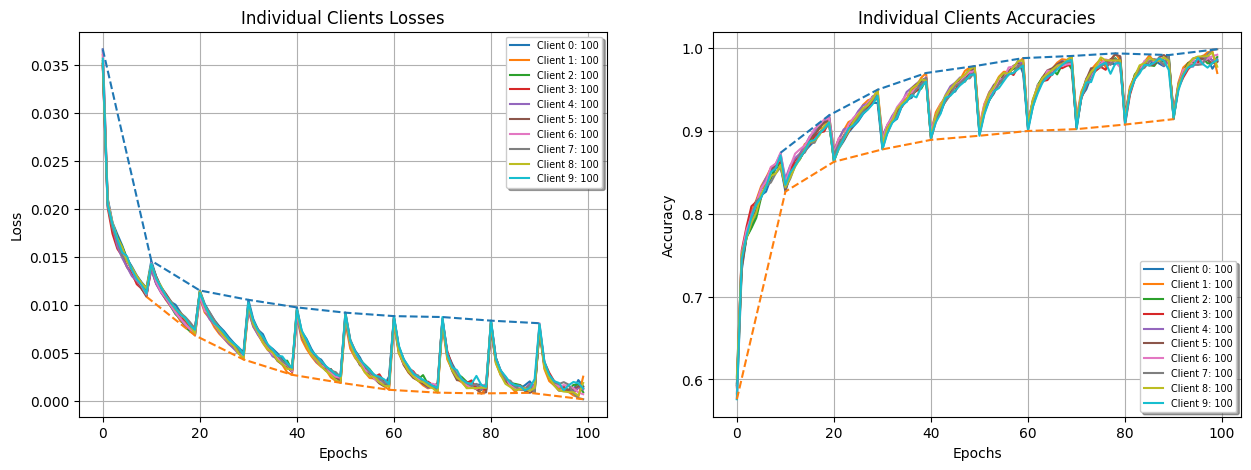

In [18]:
plot_metricss(strategy_fed_avg.client_metrics)

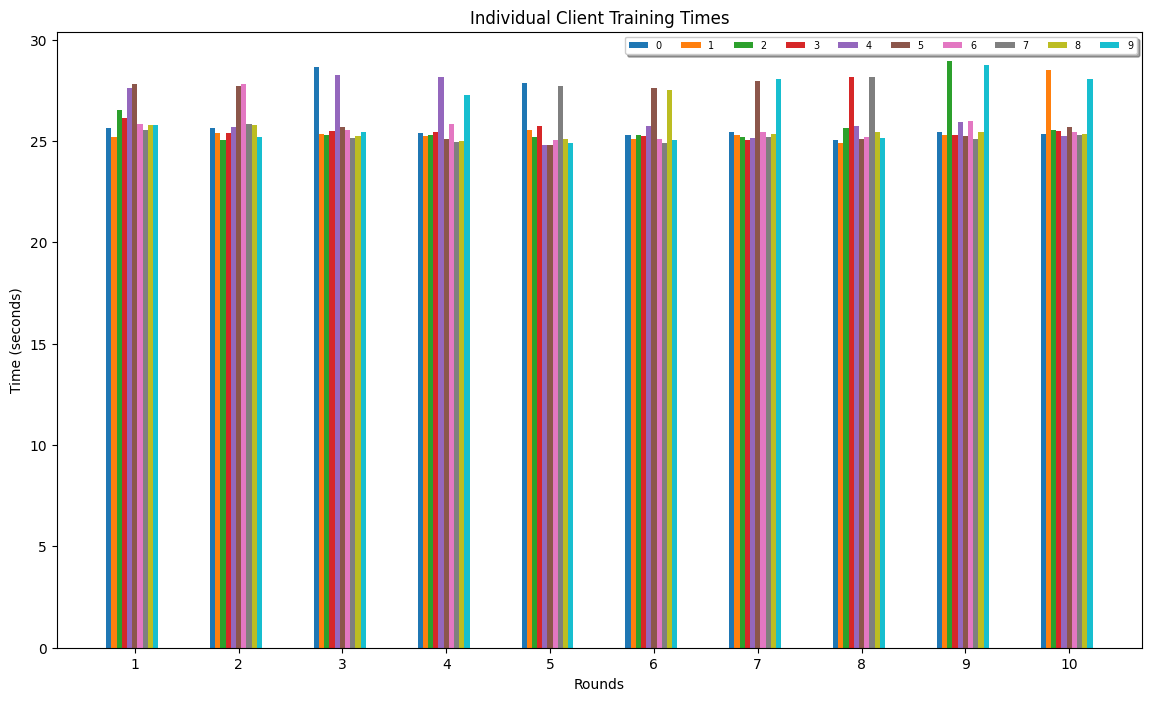

In [19]:
plot_times(strategy_fed_avg.client_training_times)

In [16]:
class FedProxCustom(fl.server.strategy.FedProx):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
        proximal_mu=1.0,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients,proximal_mu=proximal_mu)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [17]:
#strategy_fed_avg = FedAvgCustom()
#strategy_fed_prox = fl.server.strategy.FedProx(proximal_mu=1.0)
strategy_fed_prox = FedProxCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy= strategy_fed_prox,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-06 15:16:02,685	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 26120390247.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'object_store_memory': 13060195123.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55340) [Client 3] get_parameters
(ClientAppActor pid=55340) [Client 2] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55340) Epoch 0: train loss 0.036446, accuracy 0.569074
(ClientAppActor pid=55152) [Client 1] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=55340) Epoch 1: train loss 0.021194, accuracy 0.739815
(ClientAppActor pid=53776) Epoch 0: train loss 0.035518, accuracy 0.587778 [repeated 4x across cluster]
(ClientAppActor pid=52600) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=55152) Epoch 2: train loss 0.018697, accuracy 0.768889 [repeated 16x across cluster]
(ClientAppActor pid=53444) Epoch 4: train loss 0.015333, accuracy 0.812963 [repeated 20x across clust

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55152) Epoch 9: train loss 0.011025, accuracy 0.868889 [repeated 3x across cluster]
(ClientAppActor pid=55152) [Client 1] evaluate, config: {}
(ClientAppActor pid=55152) Client 1 loss 0.01703271021445592
(ClientAppActor pid=55152) Client 1 accuracy 0.785


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27268) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55152) Epoch 1: train loss 0.013271, accuracy 0.843333 [repeated 9x across cluster]
(ClientAppActor pid=27268) [Client 3] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=27268) Client 3 loss 0.016428921222686767 [repeated 9x across cluster]
(ClientAppActor pid=27268) Client 3 accuracy 0.835 [repeated 9x across cluster]
(ClientAppActor pid=53776) [Client 4] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=54980) Epoch 3: train loss 0.010690, accuracy 0.868519 [repeated 18x across cluster]
(ClientAppActor pid=52600) Epoch 5: train loss 0.009685, accuracy 0.886111 [repeated 18x across cluster]
(ClientAppActor pid=53776) Epoch 7: train loss 0.007921, accuracy 0.906481 [repeated 19x across cluster]
(ClientAppActor pid=55152) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55152) Epoch 0: train loss 0.014709, accuracy 0.832963 [r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55152) [Client 5] evaluate, config: {}
(ClientAppActor pid=51232) Client 9 loss 0.013291065916419029
(ClientAppActor pid=51232) Client 9 accuracy 0.8566666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51232) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55152) Epoch 9: train loss 0.006617, accuracy 0.922593 [repeated 3x across cluster]
(ClientAppActor pid=51232) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 4 loss 0.011997554451227188 [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 4 accuracy 0.8733333333333333 [repeated 9x across cluster]
(ClientAppActor pid=53444) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=53444) Epoch 1: train loss 0.009622, accuracy 0.884444 [repeated 16x across cluster]
(ClientAppActor pid=51232) Epoch 4: train loss 0.007412, accuracy 0.913333 [repeated 17x across cluster]
(ClientAppActor pid=27268) Epoch 6: train loss 0.006192, accuracy 0.928333 [repeated 18x across cluster]
(ClientAppActor pid=55152) Epoch 8: train loss 0.005378, accuracy 0.937963 [repeated 18x across cluster]
(ClientAppActor pid=51232) [Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=53776) [Client 6] evaluate, config: {}
(ClientAppActor pid=53776) Client 6 loss 0.010218978164096674
(ClientAppActor pid=53776) Client 6 accuracy 0.875


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51232) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=53776) Epoch 9: train loss 0.005129, accuracy 0.936481 [repeated 3x across cluster]
(ClientAppActor pid=51232) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 4 loss 0.012185708954930305 [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 4 accuracy 0.8816666666666667 [repeated 9x across cluster]
(ClientAppActor pid=52600) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=51232) Epoch 2: train loss 0.007237, accuracy 0.906667 [repeated 17x across cluster]
(ClientAppActor pid=53776) Epoch 4: train loss 0.005752, accuracy 0.932593 [repeated 17x across cluster]
(ClientAppActor pid=27268) Epoch 6: train loss 0.004345, accuracy 0.944815 [repeated 19x across cluster]
(ClientAppActor pid=27268) Epoch 8: train loss 0.003739, accuracy 0.955370 [repeated 17x across cluster]
(ClientAppActor pid=55340) [Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55340) [Client 3] evaluate, config: {}
(ClientAppActor pid=55340) Client 3 loss 0.010401944282154242
(ClientAppActor pid=55340) Client 3 accuracy 0.91


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51232) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55340) Epoch 0: train loss 0.009816, accuracy 0.889074 [repeated 4x across cluster]
(ClientAppActor pid=51232) [Client 5] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 5 loss 0.016246056109666826 [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 5 accuracy 0.8683333333333333 [repeated 9x across cluster]
(ClientAppActor pid=54980) [Client 6] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=53444) Epoch 2: train loss 0.006328, accuracy 0.926111 [repeated 17x across cluster]
(ClientAppActor pid=53776) Epoch 4: train loss 0.004342, accuracy 0.950000 [repeated 18x across cluster]
(ClientAppActor pid=52600) Epoch 6: train loss 0.003442, accuracy 0.958889 [repeated 18x across cluster]
(ClientAppActor pid=55152) Epoch 8: train loss 0.002816, accuracy 0.965556 [repeated 18x across cluster]
(ClientAppActor pid=55340) [Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=53444) [Client 4] evaluate, config: {}
(ClientAppActor pid=53444) Client 4 loss 0.015309791242082914
(ClientAppActor pid=53444) Client 4 accuracy 0.88


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55340) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=51232) Epoch 1: train loss 0.006371, accuracy 0.930185 [repeated 10x across cluster]
(ClientAppActor pid=55340) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=55340) Client 2 loss 0.014878734443336726 [repeated 9x across cluster]
(ClientAppActor pid=55340) Client 2 accuracy 0.895 [repeated 9x across cluster]
(ClientAppActor pid=55152) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=54980) Epoch 3: train loss 0.004616, accuracy 0.946296 [repeated 18x across cluster]
(ClientAppActor pid=52600) Epoch 5: train loss 0.003271, accuracy 0.961852 [repeated 18x across cluster]
(ClientAppActor pid=27268) Epoch 7: train loss 0.002063, accuracy 0.978148 [repeated 19x across cluster]
(ClientAppActor pid=51232) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=27268) Epoch 9: train loss 0.002436, accuracy 0.972593 [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55340) [Client 0] evaluate, config: {}
(ClientAppActor pid=55340) Client 0 loss 0.014019971502323945
(ClientAppActor pid=55340) Client 0 accuracy 0.87


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51232) [Client 8] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55340) Epoch 9: train loss 0.001227, accuracy 0.986667 [repeated 3x across cluster]
(ClientAppActor pid=51232) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 6 loss 0.011567604367931684 [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 6 accuracy 0.8783333333333333 [repeated 9x across cluster]
(ClientAppActor pid=27268) [Client 1] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=51232) Epoch 2: train loss 0.004088, accuracy 0.950741 [repeated 17x across cluster]
(ClientAppActor pid=54980) Epoch 4: train loss 0.003047, accuracy 0.965185 [repeated 19x across cluster]
(ClientAppActor pid=27268) Epoch 6: train loss 0.001859, accuracy 0.978519 [repeated 19x across cluster]
(ClientAppActor pid=51232) Epoch 9: train loss 0.001463, accuracy 0.984444 [repeated 18x across cluster]
(ClientAppActor pid=55152) [Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55152) [Client 4] evaluate, config: {}
(ClientAppActor pid=55152) Client 4 loss 0.018300889333089192
(ClientAppActor pid=55152) Client 4 accuracy 0.8783333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51232) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=52600) Epoch 0: train loss 0.007948, accuracy 0.911481 [repeated 4x across cluster]
(ClientAppActor pid=51232) [Client 9] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 9 loss 0.01549257575844725 [repeated 9x across cluster]
(ClientAppActor pid=51232) Client 9 accuracy 0.8783333333333333 [repeated 9x across cluster]
(ClientAppActor pid=54980) [Client 4] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=27268) Epoch 2: train loss 0.003788, accuracy 0.953519 [repeated 19x across cluster]
(ClientAppActor pid=54980) Epoch 4: train loss 0.002171, accuracy 0.974074 [repeated 17x across cluster]
(ClientAppActor pid=51232) Epoch 7: train loss 0.001047, accuracy 0.988333 [repeated 18x across cluster]
(ClientAppActor pid=51232) Epoch 9: train loss 0.000861, accuracy 0.990370 [repeated 16x across cluster]
(ClientAppActor pid=51232) [Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51232) Epoch 9: train loss 0.001223, accuracy 0.986852 [repeated 4x across cluster]
(ClientAppActor pid=53444) [Client 8] evaluate, config: {}
(ClientAppActor pid=53444) Client 8 loss 0.015696083307266236
(ClientAppActor pid=53444) Client 8 accuracy 0.8983333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55340) [Client 3] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=52600) Epoch 1: train loss 0.004182, accuracy 0.946481 [repeated 10x across cluster]
(ClientAppActor pid=55340) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=55340) Client 4 loss 0.019701233121256035 [repeated 9x across cluster]
(ClientAppActor pid=55340) Client 4 accuracy 0.8783333333333333 [repeated 9x across cluster]
(ClientAppActor pid=55152) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=27268) Epoch 3: train loss 0.002624, accuracy 0.969444 [repeated 18x across cluster]
(ClientAppActor pid=51232) Epoch 5: train loss 0.001725, accuracy 0.980000 [repeated 19x across cluster]
(ClientAppActor pid=51232) Epoch 7: train loss 0.001063, accuracy 0.988519 [repeated 18x across cluster]
(ClientAppActor pid=55340) [Client 8] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=55340) Epoch 0: train loss 0.008615, accura

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=52600) [Client 1] evaluate, config: {}
(ClientAppActor pid=52600) Client 1 loss 0.011922904973228772
(ClientAppActor pid=52600) Client 1 accuracy 0.9066666666666666


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55340) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=52600) Epoch 9: train loss 0.001745, accuracy 0.978333 [repeated 3x across cluster]
(ClientAppActor pid=55340) [Client 9] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=55340) Client 9 loss 0.01605554251621167 [repeated 9x across cluster]
(ClientAppActor pid=55340) Client 9 accuracy 0.8816666666666667 [repeated 9x across cluster]
(ClientAppActor pid=53776) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 7x across cluster]
(ClientAppActor pid=53776) Epoch 1: train loss 0.003469, accuracy 0.958519 [repeated 16x across cluster]
(ClientAppActor pid=53776) Epoch 3: train loss 0.001838, accuracy 0.979259 [repeated 16x across cluster]
(ClientAppActor pid=52600) Epoch 6: train loss 0.001484, accuracy 0.984444 [repeated 17x across cluster]
(ClientAppActor pid=27268) Epoch 8: train loss 0.001324, accuracy 0.985370 [repeated 19x across cluster]
(ClientAppActor pid=52600) [Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=52600) [Client 3] evaluate, config: {}
(ClientAppActor pid=52600) Client 3 loss 0.014496358525939286
(ClientAppActor pid=52600) Client 3 accuracy 0.9133333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 537.23s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.017741431723038353
INFO :      		round 2: 0.0116412945240736
INFO :      		round 3: 0.011660145744681358
INFO :      		round 4: 0.012247130823632081
INFO :      		round 5: 0.013334795873922606
INFO :      		round 6: 0.01435040913351501
INFO :      		round 7: 0.015437558490394925
INFO :      		round 8: 0.016105129582807423
INFO :      		round 9: 0.016821324969952305
INFO :      		round 10: 0.017561817697094133
INFO :      


History (loss, distributed):
	round 1: 0.017741431723038353
	round 2: 0.0116412945240736
	round 3: 0.011660145744681358
	round 4: 0.012247130823632081
	round 5: 0.013334795873922606
	round 6: 0.01435040913351501
	round 7: 0.015437558490394925
	round 8: 0.016105129582807423
	round 9: 0.016821324969952305
	round 10: 0.017561817697094133

In [18]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_prox.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

#plot_metrics(strategy.client_metrics)

(ClientAppActor pid=52600) Client 7 loss 0.01766388079772393
(ClientAppActor pid=52600) Client 7 accuracy 0.885


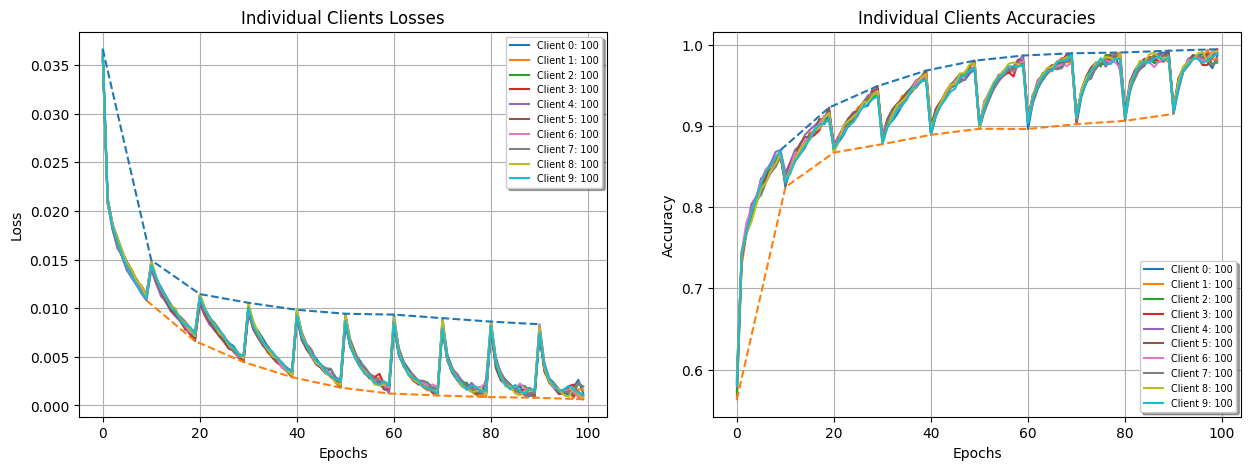

In [19]:
plot_metricss(strategy_fed_prox.client_metrics)


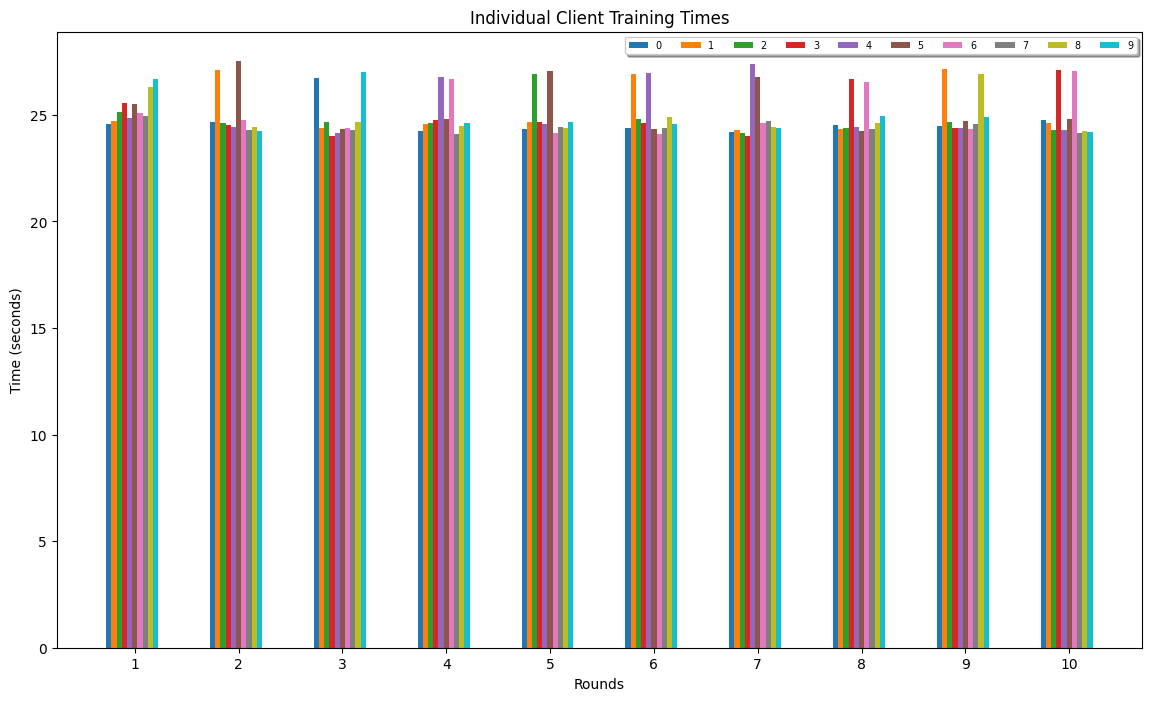

In [20]:
plot_times(strategy_fed_prox.client_training_times)